<a href="https://colab.research.google.com/github/SijieQiu/RQ/blob/main/lda_wordcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

Saving c.txt to c.txt
Saving data.docx to data.docx
Saving data.txt to data.txt


In [5]:
!pip install tomotopy
import pandas as pd
import jieba
from sklearn.feature_extraction.text import CountVectorizer
import tomotopy as tp
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 49.7 MB/s eta 0:00:00


In [6]:
# 下载并加载 spaCy 模型
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

# 读取数据文件
data_file = 'data.txt'
data = pd.read_csv(data_file, sep='\t', header=None, names=['文本数据', '标签'])

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
# 处理缺失值（如果有）
data = data.dropna()

In [8]:
# 读取停用词文件
stopwords_file = 'c.txt'
with open(stopwords_file, 'r', encoding='utf-8') as f:
    stopwords = set(f.read().strip().split('\n'))

In [9]:
# 扩展停用词列表，包含常见的外国人名和代词
additional_stopwords = set(['she', 'he', 'it', 'they', 'them', 'his', 'her', 'their', 'him', 'her', 'John', 'Mary', 'Michael', 'Sarah','Victoria','Nida',  'Dawson','Hector' ,'Nish', 'Cliff' ])  # 添加更多人名和代词
stopwords.update(additional_stopwords)


In [10]:
# 分词并过滤停用词和人名
def preprocess(text):
    doc = nlp(text)
    words = [token.text for token in doc if token.ent_type_ != 'PERSON']
    return [word for word in words if word.lower() not in stopwords and len(word) > 1]

In [11]:
# 预处理文本数据
processed_texts = [' '.join(preprocess(text)) for text in data['文本数据']]

# 定义标签
labels = [label.split(',') for label in data['标签']]

# 向量化
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_texts)

# 转换标签为整数列表
label_set = set(sum(labels, []))
label_map = {label: idx for idx, label in enumerate(label_set)}
Y = []
for doc_labels in labels:
    doc_labels_int = [label_map[label] for label in doc_labels]
    Y.append(doc_labels_int)

# 创建语料库
corpus = tp.utils.Corpus()
for text in processed_texts:
    corpus.add_doc(text.split())

In [12]:
# 创建并训练 PT-LDA 模型
num_topics = 10  # 确保主题数为10
model = tp.PTModel(k=num_topics)
for doc_idx, doc in enumerate(corpus):
    model.add_doc(doc, Y[doc_idx])  # 将标签作为位置参数传递

model.train(100)

In [13]:
# 输出每个主题的关键词
for k in range(model.k):
    print(f'Topic {k}:')
    for word, prob in model.get_topic_words(k, top_n=10):
        print(f'{word}: {prob:.4f}')
    print()

Topic 0:
house: 0.0291
walks: 0.0207
runs: 0.0192
technology: 0.0138
telling: 0.0130
knife: 0.0123
husband: 0.0115
glass: 0.0115
days: 0.0107
eating: 0.0100

Topic 1:
Ashley: 0.0533
woman: 0.0256
Cole: 0.0171
Dr.: 0.0160
questions: 0.0160
continues: 0.0117
hears: 0.0117
door: 0.0117
crew: 0.0107
pushes: 0.0107

Topic 2:
Shazia: 0.0448
Carrie: 0.0371
Nish: 0.0325
Victoria: 0.0294
Hector: 0.0224
Dawson: 0.0209
pictures: 0.0186
Rolo: 0.0162
picture: 0.0147
Parker: 0.0139

Topic 3:
Cliff: 0.1096
Krish: 0.0252
dog: 0.0174
family: 0.0165
Salma: 0.0165
San: 0.0157
Sandy: 0.0157
Lana: 0.0157
Junipero: 0.0139
Earth: 0.0122

Topic 4:
Rachel: 0.0172
Bear: 0.0161
drive: 0.0151
television: 0.0140
roaches: 0.0118
Stripe: 0.0118
dad: 0.0118
talking: 0.0108
light: 0.0108
brain: 0.0097

Topic 5:
Vicky: 0.0234
kill: 0.0234
wife: 0.0178
mother: 0.0159
door: 0.0150
company: 0.0131
nearby: 0.0131
police: 0.0122
killed: 0.0103
campaign: 0.0094

Topic 6:
pulls: 0.0288
offers: 0.0194
camera: 0.0154
story: 0.0

In [15]:
# 生成词云图
def create_wordcloud(topic_num):
    topic_words = model.get_topic_words(topic_num, top_n=50)
    word_freq = {word: prob for word, prob in topic_words}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    return wordcloud

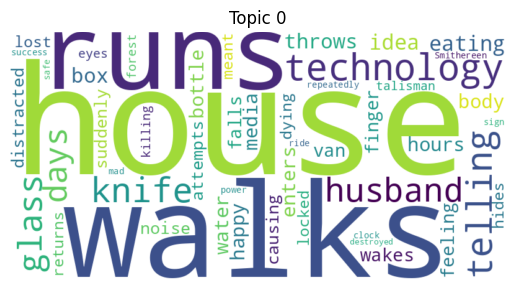

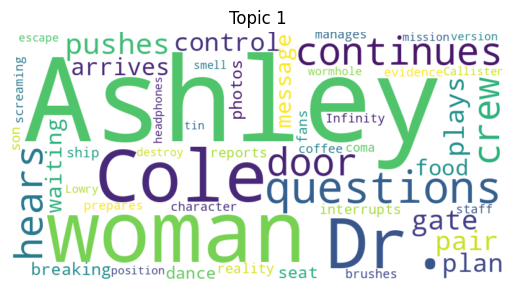

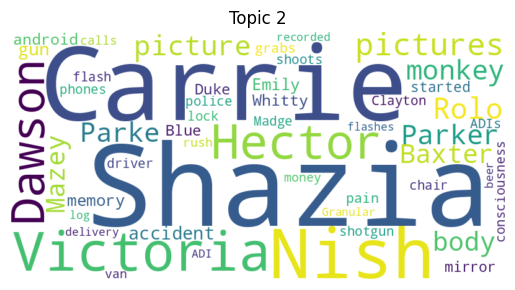

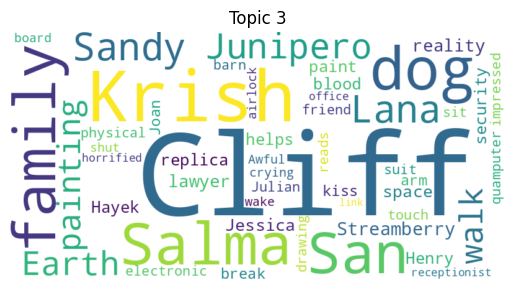

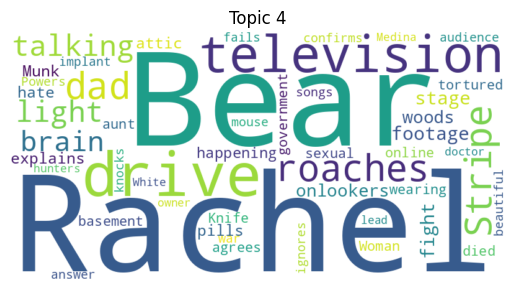

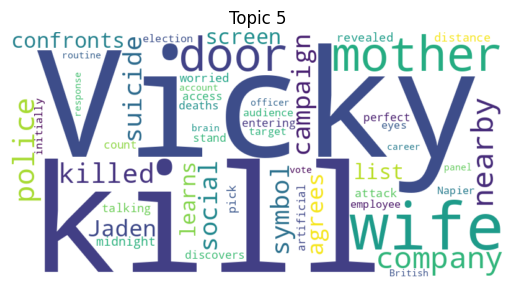

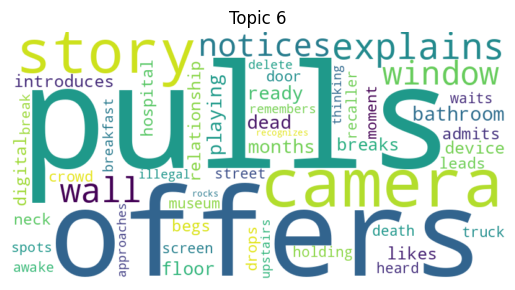

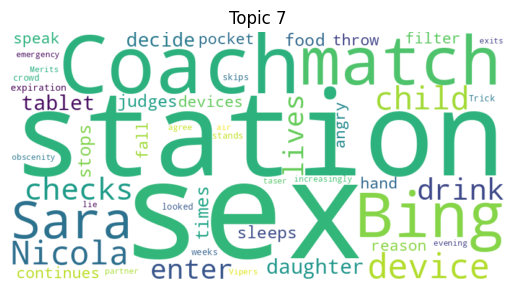

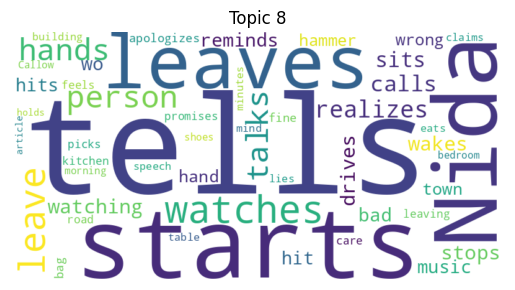

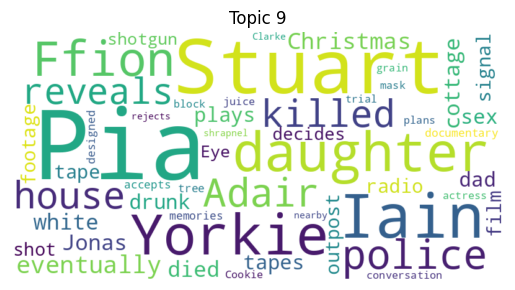

In [17]:
# prompt: print all wordcloud

import matplotlib.pyplot as plt
for topic_num in range(num_topics):
  wordcloud = create_wordcloud(topic_num)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Topic {topic_num}")
  plt.show()
